## Preliminaries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Set random seeds
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/richardlee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/richardlee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/richardlee/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/richardlee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [11]:
# Load in dataset
df = pd.read_csv("Project1-ClassificationDataset.csv")
# df.head()

## Geting familiar with the dataset

### Question 1

In [12]:
# Overview
numrows = df.shape[0]
numcols = df.shape[1]

print("There are", numrows, "rows in the dataset.")
print("There are", numcols, "columns in the dataset.")

There are 3476 rows in the dataset.
There are 8 columns in the dataset.


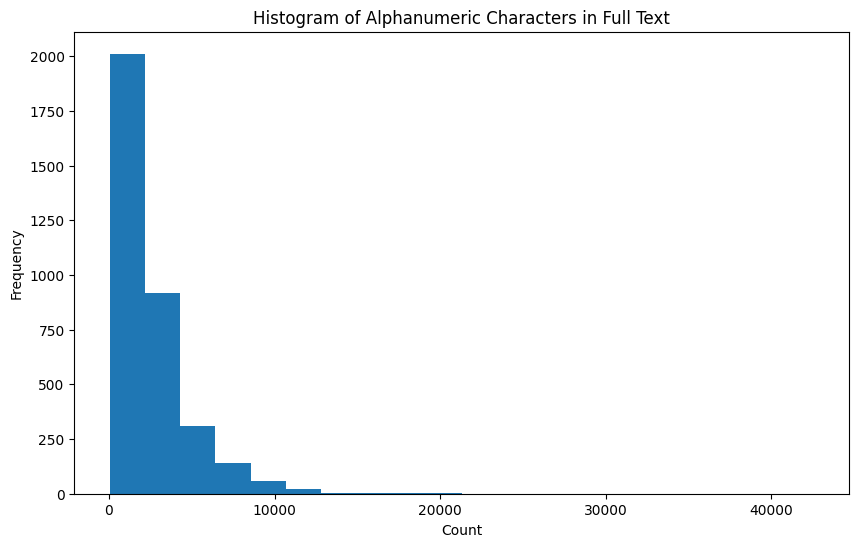

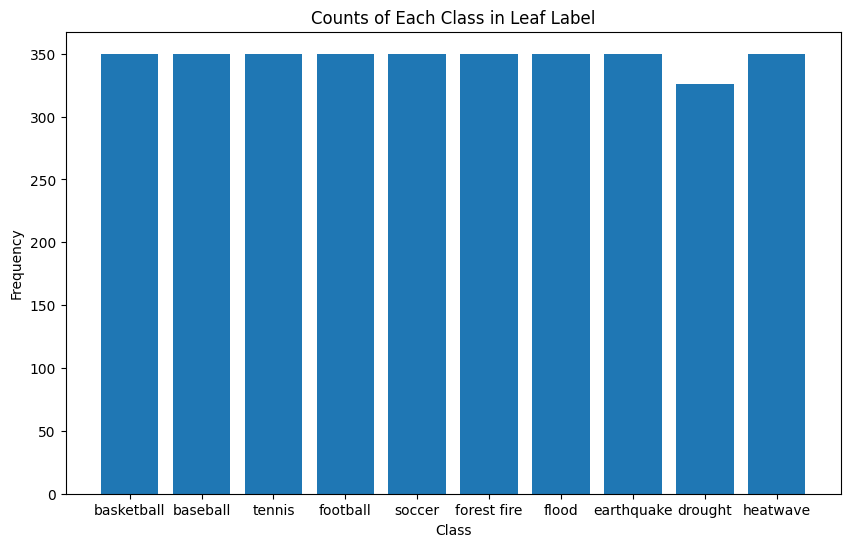

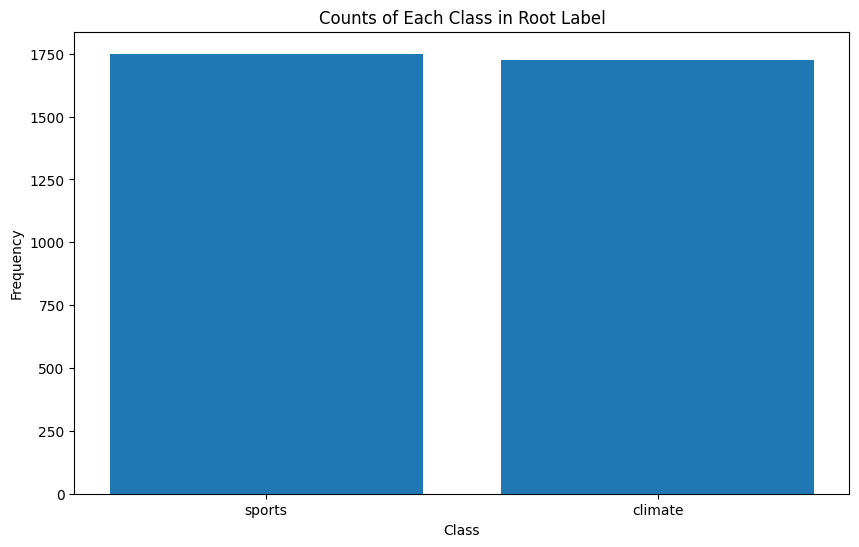

In [4]:
# Histograms
def count_alphanumeric(text = str) -> int:
  """
  Counts the number of alphanumeric characters in a string.

  Parameters
  ----------
  text : str
    The string to count the alphanumeric characters in.

  Returns
  -------
  int
    The number of alphanumeric characters in the string.
  """
  count = 0
  for char in text:
    if char.isalnum():
      count += 1
  return count

def count_classes(df = pd.DataFrame, col = str) -> list:
  """
  Counts the number of classes in a column of a dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to count the classes in.
  col : str
    The column to count the classes in.

  Returns
  -------
  2 lists
    A list of classes and a list of the counts of classes in the column.
  """
  classes = df[col].unique()
  counts = []
  for unique_class in classes:
    counts.append(df[col].str.contains(unique_class).sum())
  return classes, counts

# Keep track of counts of alphanumeric characters
count_alphanumeric_full_text = []
for text in df['full_text']:
  count_alphanumeric_full_text.append(count_alphanumeric(text))

# Keep track of counts of each class
classes_leaf_label, count_classes_leaf_label = count_classes(df, 'leaf_label')
classes_root_label, count_classes_root_label = count_classes(df, 'root_label')

# Histogram of alphanumeric characters
plt.figure(figsize=(10, 6))
plt.hist(count_alphanumeric_full_text, bins = 20)
plt.title('Histogram of Alphanumeric Characters in Full Text')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in leaf_label
plt.figure(figsize=(10, 6))
plt.bar(classes_leaf_label, count_classes_leaf_label)
plt.title('Counts of Each Class in Leaf Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in root_label
plt.figure(figsize=(10, 6))
plt.bar(classes_root_label, count_classes_root_label)
plt.title('Counts of Each Class in Root Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

The number of alpha-numeric characters per data point appears to follow an exponential distribution with nearly all documents containing 10000 or fewer alpha-numeric characters. There also appears to be a balanced set of classes for the leaf_label column with only drought having a slightly lower frequency. For the root_label column, the sports and climate classes are nearly balanced with sports having a marginally higher frequency.

## Binary Classification

### 1. Splitting the entire dataset into training and testing data

In [5]:
# Set seeds
np.random.seed(42)
random.seed(42)

# Split dataset
train, test = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

### Question 2

In [15]:
# Count number of rows in train and test
num_train = train.shape[0]
num_test = test.shape[0]

# Display results
print("Number of rows in train:", num_train)
print("Number of rows in test:", num_test)


Number of rows in train: 2780
Number of rows in test: 696


### 2. Feature Extraction

### Question 3

In [6]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_numbers(text = str) -> str:
  """
  Removes numbers from the text.

  Parameters
  ----------
  text : str
    The string to remove numbers from.

  Returns
  -------
  str
    The string with numbers removed.
  """

  # Remove numbers
  return re.sub(r'\b\d+\b', '', text)

def remove_punctuation(text = str) -> str:
  """
  Removes punctuation from the text.

  Parameters
  ----------
  text : str
    The string to remove punctuation from.

  Returns
  -------
  str
    The string with punctuation removed.
  """

  # Remove punctuation
  return re.sub(r'[^\w\s]', '', text)

def lemmatize(text = str) -> str:
  """
  Lemmatizes the text.

  Parameters
  ----------
  text : str
    The string to lemmatize.

  Returns
  -------
  str
    The lemmatized string.
  """

  # Helper function for part of speech
  def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Get tokens
  words = text.split()

  # Get part of speech
  pos_tags = pos_tag(words)

  # Lemmatize each word
  words_lemmatize = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

  # Join words back together
  return " ".join(words_lemmatize)

def stemming(text = str) -> str:
  """
  Stems the text.

  Parameters
  ----------
  text : str
    The string to stem.

  Returns
  -------
  str
    The stemmed string.
  """

  # Initialize stemmer
  stemmer = PorterStemmer()

  # Get tokens
  words = text.split()

  # Stem each word
  words_stem = [stemmer.stem(word) for word in words]

  # Join words back together
  return " ".join(words_stem)

def preprocessing(df = pd.DataFrame, preprocessing_functions = list) -> pd.DataFrame:
  """
  Preprocesses the text in the dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  preprocessing_functions : list
    The list of preprocessing functions to apply.

  Returns
  -------
  pd.DataFrame
    The preprocessed dataframe.
  """

  # Initialize dataframe
  df_copy = df.copy()

  # Apply preprocessing functions
  for preprocessing_function in preprocessing_functions:
    df_copy.map(preprocessing_function)

  return df_copy

In [7]:
# Takes about 90 seconds to complete with lemmatization
# Takes about 30 seconds to complete with stemming

# Preprocessing
# Make sure clean function is first
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]
# preprocessing_functions = [clean, remove_numbers, remove_punctuation, stemming]

X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Number of columns should be the same for train and test sets
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)
# Note that size of TF-IDF matrix remains the same for lemmatization and stemming

In [18]:
# Experiment in speed and TF-IDF size for lemmatize vs. stemming
# Takes about 2-3 minutes to complete

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Lemmatize
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]

# Time on training
start = time.time()
X_train = preprocessing(train, preprocessing_functions)
end = time.time()
print("Time taken for lemmatization on training set: " + str(round(end - start, 2)) + " seconds.")

# Size of TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print("Number of columns in TF-IDF matrix on training set after lemmatization: " + str(X_train_tfidf.shape[1]))
print()

# Time on test
start = time.time()
X_test = preprocessing(test, preprocessing_functions)
end = time.time()
print("Time taken for lemmatization on test set: " + str(round(end - start, 2)) + " seconds.")

# Size of TF-IDF matrix
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print("Number of columns in TF-IDF matrix on test set after lemmatization: " + str(X_test_tfidf.shape[1]))
print()

# Stemming
preprocessing_functions = [clean, remove_numbers, remove_punctuation, stemming]

# Time on training
start = time.time()
X_train = preprocessing(train, preprocessing_functions)
end = time.time()
print("Time taken for stemming on training set: " + str(round(end - start, 2)) + " seconds.")

# Size of TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print("Number of columns in TF-IDF matrix on training set after stemming: " + str(X_train_tfidf.shape[1]))
print()

# Time on test
start = time.time()
X_test = preprocessing(test, preprocessing_functions)
end = time.time()
print("Time taken for stemming on test set: " + str(round(end - start, 2)) + " seconds.")

# Size of TF-IDF matrix
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print("Number of columns in TF-IDF matrix on test set after stemming: " + str(X_test_tfidf.shape[1]))
print()


Time taken for lemmatization on training set: 74.68 seconds.
Number of columns in TF-IDF matrix on training set after lemmatization: 17330

Time taken for lemmatization on test set: 21.07 seconds.
Number of columns in TF-IDF matrix on test set after lemmatization: 17330

Time taken for stemming on training set: 24.42 seconds.
Number of columns in TF-IDF matrix on training set after stemming: 17330

Time taken for stemming on test set: 7.64 seconds.
Number of columns in TF-IDF matrix on test set after stemming: 17330



In [19]:
# Experiment with changing min_df
# Takes about 1-2 minutes to complete
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]

X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

min_dfs = [3, 4, 5, 6, 7, 8, 9, 10]

for mindf in min_dfs:

  # Initialize CountVectorizer and TfidfTransformer
  count_vect = CountVectorizer(stop_words = 'english', min_df = mindf)
  tfidf_transformer = TfidfTransformer()

  # Remove stopwords and convert to TF-IDF matrix
  X_train_counts = count_vect.fit_transform(X_train['full_text'])
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
  X_test_counts = count_vect.transform(X_test['full_text'])
  X_test_tfidf = tfidf_transformer.transform(X_test_counts)

  # Print number of columns in tfidf
  print("Train: Number of columns in tfidf for min_df = " + str(mindf) + ": " + str(X_train_tfidf.shape[1]))
  print("Test: Number of columns in tfidf for min_df = " + str(mindf) + ": " + str(X_test_tfidf.shape[1]))
  print()


Train: Number of columns in tfidf for min_df = 3: 17330
Test: Number of columns in tfidf for min_df = 3: 17330

Train: Number of columns in tfidf for min_df = 4: 14237
Test: Number of columns in tfidf for min_df = 4: 14237

Train: Number of columns in tfidf for min_df = 5: 12284
Test: Number of columns in tfidf for min_df = 5: 12284

Train: Number of columns in tfidf for min_df = 6: 10802
Test: Number of columns in tfidf for min_df = 6: 10802

Train: Number of columns in tfidf for min_df = 7: 9746
Test: Number of columns in tfidf for min_df = 7: 9746

Train: Number of columns in tfidf for min_df = 8: 8914
Test: Number of columns in tfidf for min_df = 8: 8914

Train: Number of columns in tfidf for min_df = 9: 8253
Test: Number of columns in tfidf for min_df = 9: 8253

Train: Number of columns in tfidf for min_df = 10: 7628
Test: Number of columns in tfidf for min_df = 10: 7628



### TODO: Verify answers with experiments (i.e. change order of preprocessing steps for before/after lemmatizing)

**Pros and Cons of lemmatization vs. stemming**

The advantage of lemmatization is that it accounts for context and is more robust by using morphological information. This allows lemmatization to be relatively more accurate. Stemming takes a simpler approach by removing suffixes (i.e. the rightmost letters) to find the root word. While this approach is simpler and allows stemming to be faster than lemmatization, stemming is generally less accurate.

In short, the tradeoff between between lemmatization and stemming is between speed (stemming preferred) and accuracy (lemmatization preferred).

Per our experiment above, stemming is about twice as fast as lemmatization and leads to a smaller dictionary size. The dictionary size was inferred from fewer columns in the TF-IDF matrix.

**Changing minimum document frequency**

Increasing the minimum document frequency means that words will have to appear in more documents to be kept. This higher threshold leads to fewer words being kept, ultimately decreasing the number of columns in the TF-IDF matrix.

Per our experiment above, using a min_df between 3 and 6 yields approximately 10^4 columns whereas using a min_df between 7 and 10 yields approximately 10^3 columns.

**Before and after lemmatizing**

Performing additional preprocessing steps before or after lemmatizing comes down to choosing between retaining context and computation time. Removing stopwords, punctuations, and numbers before lemmatizing will require less computational overhead using lemmatizing. Keeping stopwords, punctuations, and numbers will allows context to be retained for lemmatization. In general, if stopwords, punctuations, and numbers contribute little to the context of the document with respect to the classes the documents are a part of, then it may be fine to remove them prior to lemmatization.

In the context of this project, we choose to perform lemmatization after removing stopwords, punctuations, and numbers. We assume that stopwords, punctuations, and numbers contribute little to the context (i.e. they do not help distinguish between whether a document is about sports or climate).



### 3. Dimensionality Reduction

### Question 4

In [20]:
# Preprocessing
# Make sure clean function is first
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]
X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Number of columns should be the same for train and test sets
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

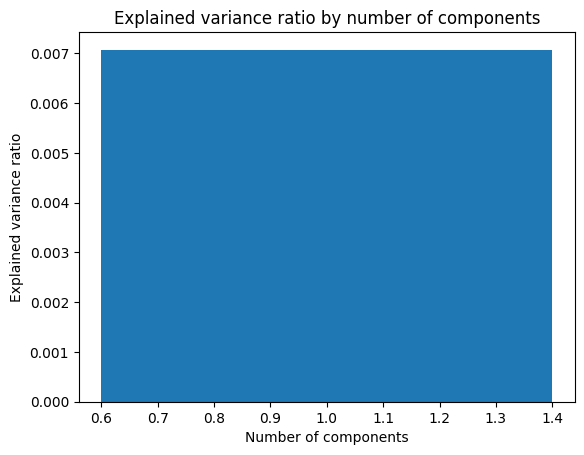

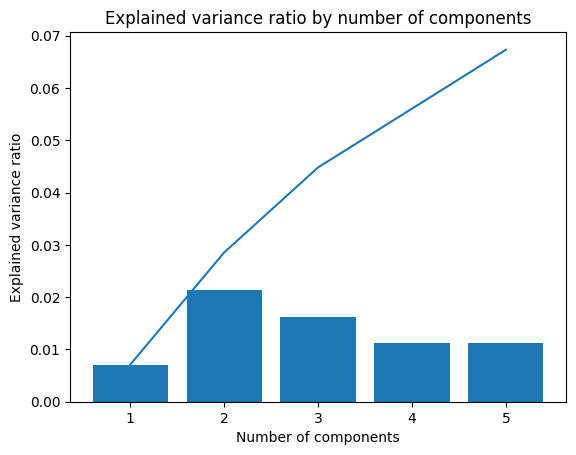

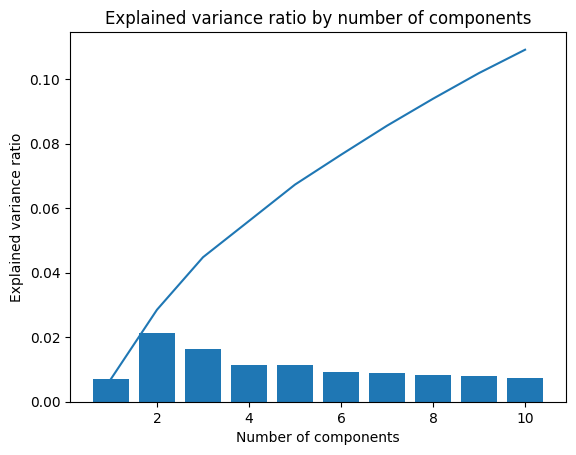

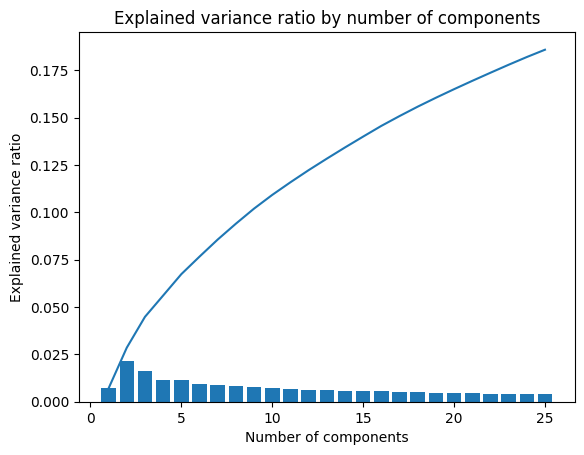

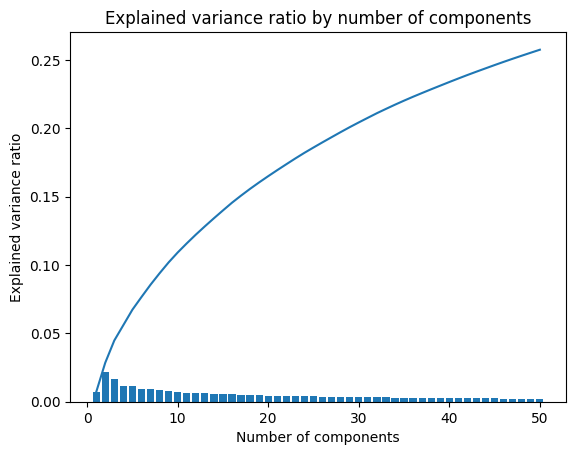

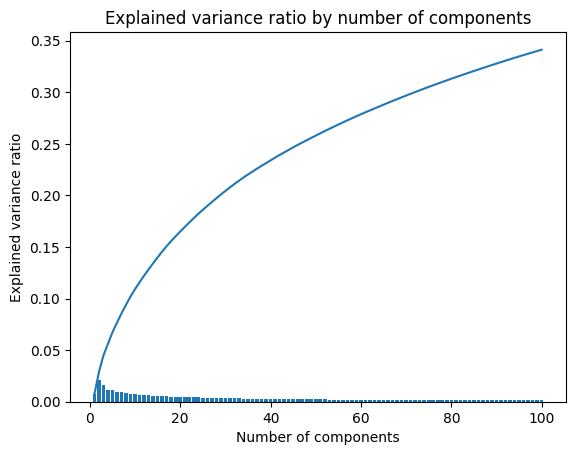

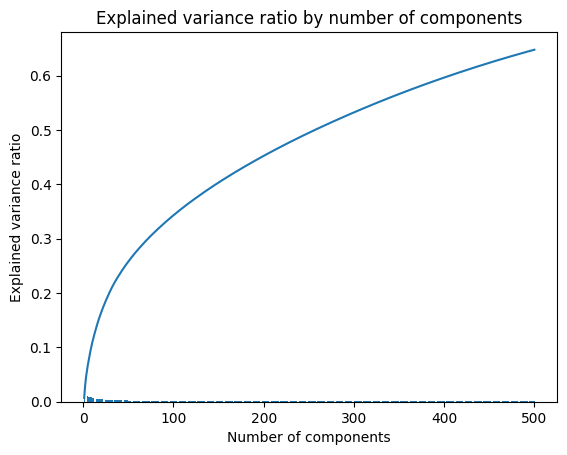

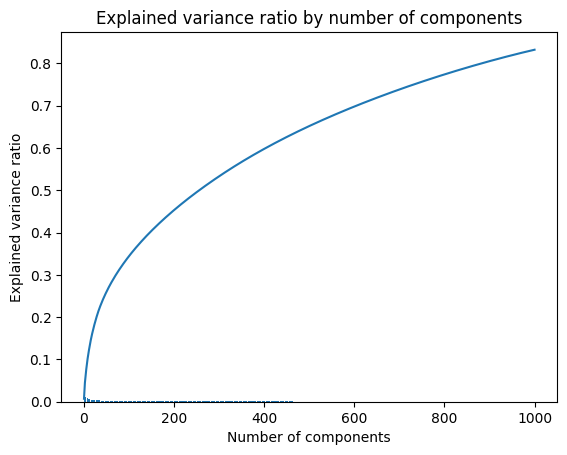

In [21]:
# Experiment with different explained variance ratios
# Takes about 45 seconds to run
k = [1, 5, 10, 25, 50, 100, 500, 1000]

for i in k:
  svd = TruncatedSVD(n_components = i)
  lsa_matrix = svd.fit_transform(X_train_tfidf)
  explained_variance_ratio = svd.explained_variance_ratio_
  cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

  # Plot explained variance ratio (bar plot) and cumulative explained variance ratio (line plot)
  plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
  plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance ratio')
  plt.title('Explained variance ratio by number of components')
  plt.show()


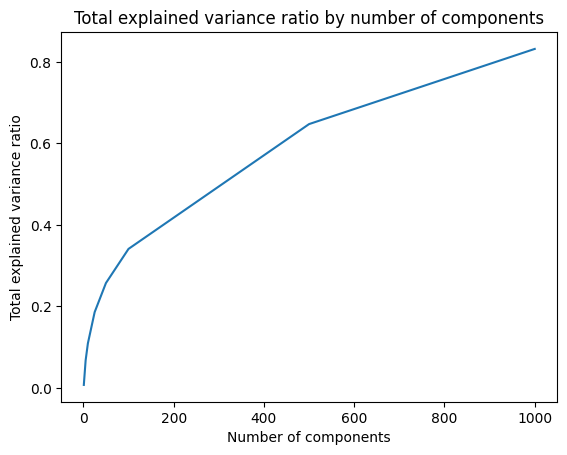

In [22]:
# Experiment with different explained variance ratios
# Takes about 30-40 seconds to run
k = [1, 5, 10, 25, 50, 100, 500, 1000]
total_explained_variance = []
for i in k:
  svd = TruncatedSVD(n_components = i)
  lsa_matrix = svd.fit_transform(X_train_tfidf)
  explained_variance_ratio = svd.explained_variance_ratio_
  total_explained_variance.append(sum(explained_variance_ratio))

# Plot explained variance ratio
plt.plot(k, total_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance ratio')
plt.title('Total explained variance ratio by number of components')
plt.show()

Let k be the number of the largest singular values of the term-document TF-IDF matrix. The plot indicates that a higher k leads to a greater explained variance ratio. The plot is concave down, suggesting diminishing returns in increasing explained variance for greater k.

In [23]:
# Perform NMF using k = 25
start = time.time()
model = NMF(n_components = 25, init = 'random', random_state = 42)
W_train = model.fit_transform(X_train_tfidf)
H = model.components_
end = time.time()
print("Time taken for NMF: " + str(round(end - start, 2)) + " seconds.")

# Calculate MSE
mse = np.sum(np.array(X_train_tfidf - W_train.dot(H))**2)
print("MSE for NMF using k = 25: ", mse)

Time taken for NMF: 12.7 seconds.
MSE for NMF using k = 25:  2220.1325252071497


In [24]:
# Perform LSI using k = 25
start = time.time()
svd = TruncatedSVD(n_components = 25)
lsa_matrix = svd.fit_transform(X_train_tfidf)
end = time.time()
print("Time taken for LSI: " + str(round(end - start, 2)) + " seconds.")

# Reconstruct matrix
reconstructed_matrix = svd.inverse_transform(lsa_matrix)

# Calculate MSE
mse = np.sum(np.array(X_train_tfidf - reconstructed_matrix)**2)
print("MSE for LSI using k = 25: ", mse)


Time taken for LSI: 0.47 seconds.
MSE for LSI using k = 25:  2203.577845928249


The MSE for LSI is slightly lower than the MSE for NMF. However, LSI was significantly faster by two orders of magnitude.

One reason why LSI is more accurate than NMF is because of the constraints that NMF are under. NMF demands non-negative values whereas LSI does not. This additional constraint means that the space where LSI can minimize error is larger than that of NMF. This allows LSI to have the possibility of lowering MSE in areas that NMF cannot.

In [25]:
# For classification, preprocess X_train_tfidf and X_test_tfidf using the code in this cell
# Takes about 90 seconds to run

# Preprocessing
# Make sure clean function is first
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]
X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Number of columns should be the same for train and test sets
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

# Apply LSI with k = 25
svd = TruncatedSVD(n_components = 25, random_state = 42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

### 4. Classification Algorithms

In [26]:
# Evaluation functions

def classifier_metrics(y_true = list, y_pred = list, model_name = "Model"):
  """
  Prints the metrics for a classifier.

  Parameters
  ----------
  y_true : list
    The true labels.
  y_pred : list
    The predicted labels.
  model_name : str
    The name of the model.

  Returns
  -------
  None
  """

  # Print metrics
  print(model_name)
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("Precision: ", precision_score(y_true, y_pred, pos_label = 'sports'))
  print("Recall: ", recall_score(y_true, y_pred, pos_label = 'sports'))
  print("F1 score: ", f1_score(y_true, y_pred, pos_label = 'sports'))
  print()

def plot_roc_curve(y_true = list, y_pred_prob = list, model_name = "Model"):
    """
    Plots the ROC curve for a binary classifier.

    Parameters
    ----------
    y_true : list
        The true labels.
    y_pred_prob : list
        The predicted probabilities.
    model_name : str
        The name of the model.

    Returns
    -------
    None
    """

    # Binarize string labels
    lb = LabelBinarizer(pos_label = 1)
    y_true = lb.fit_transform(y_true)

    # Compute the ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color = 'blue', lw = 2, label = f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color = 'black', lw = 2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc = "lower right")
    plt.grid(alpha = 0.7)
    plt.show()

### Question 5

Hard margin (gamma = 2000)
Accuracy:  0.9396551724137931
Precision:  0.9429347826086957
Recall:  0.9429347826086957
F1 score:  0.9429347826086957

Confusion matrix for hard margin (gamma = 2000):


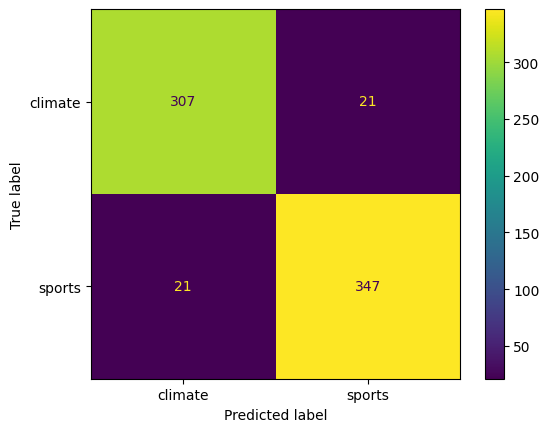

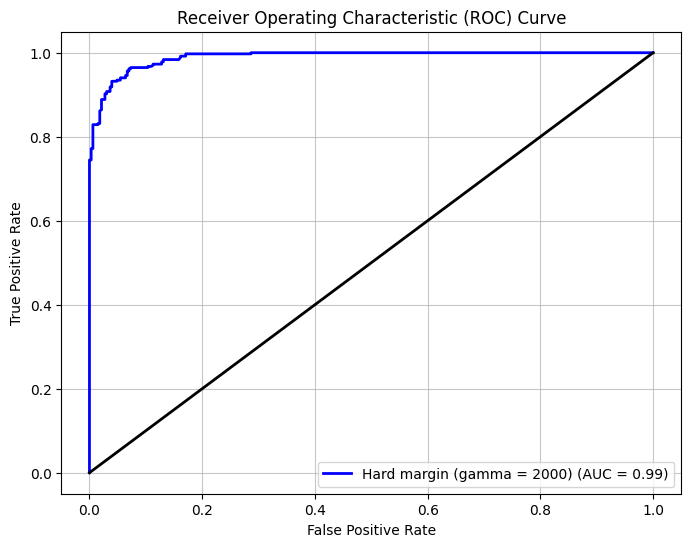

Soft margin (gamma = 0.0005)
Accuracy:  0.9367816091954023
Precision:  0.945054945054945
Recall:  0.9347826086956522
F1 score:  0.9398907103825137

Confusion matrix for soft margin (gamma = 0.0005):


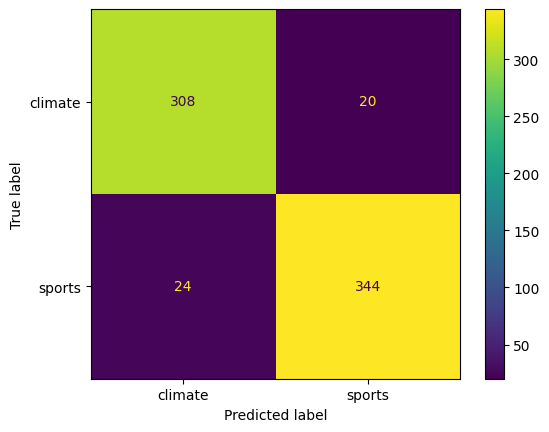

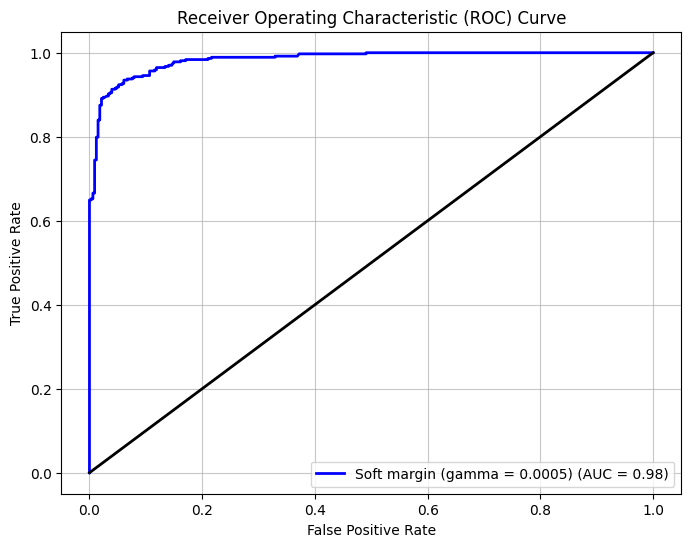

Hardest margin (gamma = 100000)
Accuracy:  0.9396551724137931
Precision:  0.9429347826086957
Recall:  0.9429347826086957
F1 score:  0.9429347826086957

Confusion matrix for hardest margin (gamma = 100000):


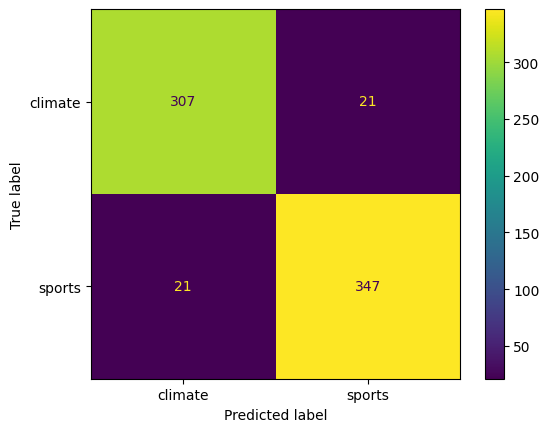

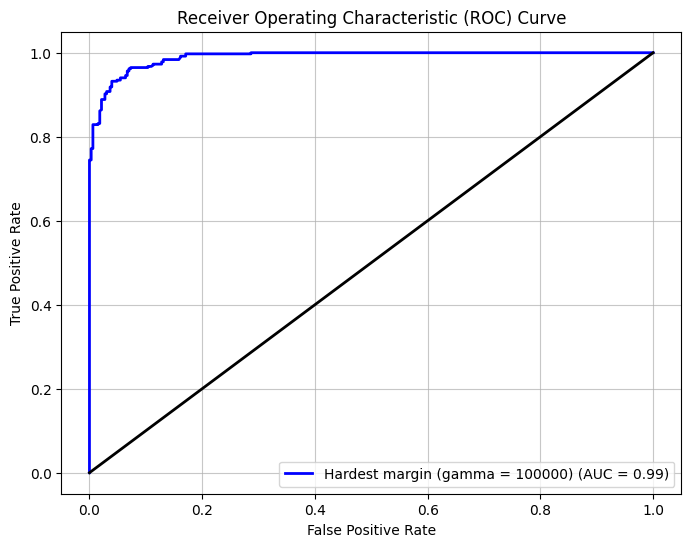

In [27]:
# Train linear SVM

# Hard margin (gamma = 2000)
hard_model = LinearSVC(C = 2000, random_state = 42)

# Soft margin (gamma = 0.0005)
soft_model = LinearSVC(C = 0.0005, random_state = 42)

# Hardest margin (gamma = 100000)
hardest_model = LinearSVC(C = 100000, random_state = 42)

# Train models and make predictions
y_pred_hard = hard_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_hard_prob = hard_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)
y_pred_soft = soft_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_soft_prob = soft_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)
y_pred_hardest = hardest_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_hardest_prob = hardest_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)

# Evaluate
# Designate sports as positive label and climate as negative label
# Switching the labels does change the metrics slightly

# Hard margin
classifier_metrics(test['root_label'], y_pred_hard, "Hard margin (gamma = 2000)")
print("Confusion matrix for hard margin (gamma = 2000):")
cm = confusion_matrix(test['root_label'], y_pred_hard)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = hard_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_hard_prob, "Hard margin (gamma = 2000)")

# Soft margin
classifier_metrics(test['root_label'], y_pred_soft, "Soft margin (gamma = 0.0005)")
print("Confusion matrix for soft margin (gamma = 0.0005):")
cm = confusion_matrix(test['root_label'], y_pred_soft)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = soft_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_soft_prob, "Soft margin (gamma = 0.0005)")

# Hardest margin
classifier_metrics(test['root_label'], y_pred_hardest, "Hardest margin (gamma = 100000)")
print("Confusion matrix for hardest margin (gamma = 100000):")
cm = confusion_matrix(test['root_label'], y_pred_hardest)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = hardest_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_hardest_prob, "Hardest margin (gamma = 100000)")

Let sports be designated as the positive label and climate be the negative label. For the SVM, the soft margin gives slightly lower performance on all metrics than the hard and the hardest margins. Precisely, as shown in the confusion matrices, the soft margin reports more false positives. This suggests that the soft margin is makes the model overfit the training data.

The ROC curve agrees with these findings. The AUC for the soft margin SVM is 0.98 whereas the AUC for the hard and the hardest margins are 0.99. This also suggests that the soft margin SVM is overfitting to the training data.

In theory, the soft margin SVM penalizes individual misclassifications less than the hard or hardest margin SVMs. This causes the false positive rate to go up.

Best margin (gamma = 10000)
Accuracy:  0.9396551724137931
Precision:  0.9429347826086957
Recall:  0.9429347826086957
F1 score:  0.9429347826086957

Confusion matrix for best margin (gamma = 10000):


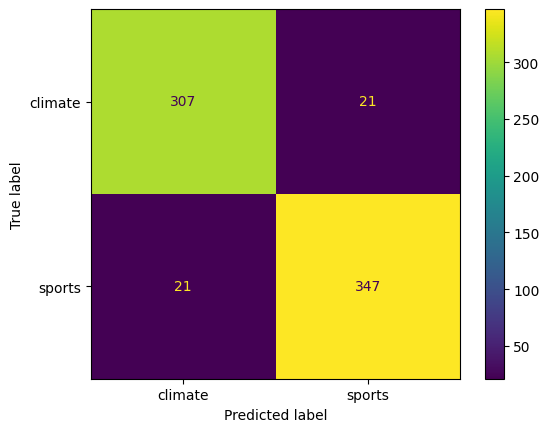

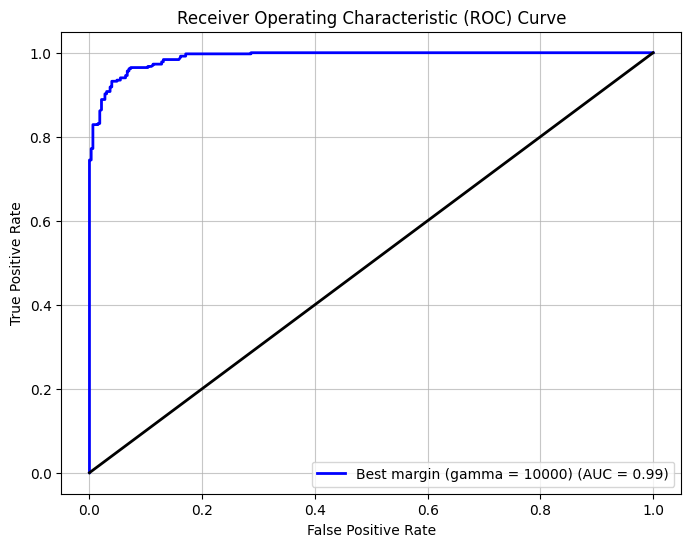

In [28]:
# Perform 5-fold cross validation to choose best gamma
model = LinearSVC(random_state = 42)

# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

# Perform grid search to find best parameter
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train_reduced, train['root_label'])

# Get best parameter
best_param = grid_search.best_params_['C']

# Fit model using best parameter
best_model = LinearSVC(C = best_param, random_state = 42)
best_model.fit(X_train_reduced, train['root_label'])
y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_best_svm = y_pred_best # Keep for McNemar's test
y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)

# Metrics
classifier_metrics(test['root_label'], y_pred_best, "Best margin (gamma = " + str(best_param) + ")")
print("Confusion matrix for best margin (gamma = " + str(best_param) + "):")
cm = confusion_matrix(test['root_label'], y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_best_prob, "Best margin (gamma = " + str(best_param) + ")")

### Question 6

Logistic Regression without penalty
Accuracy:  0.9425287356321839
Precision:  0.9456521739130435
Recall:  0.9456521739130435
F1 score:  0.9456521739130435

Confusion matrix for logistic regression without penalty:


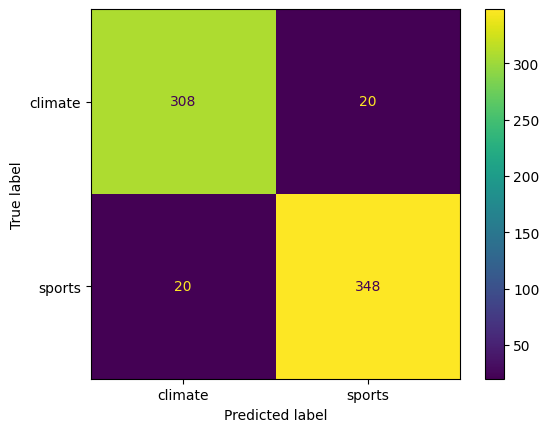

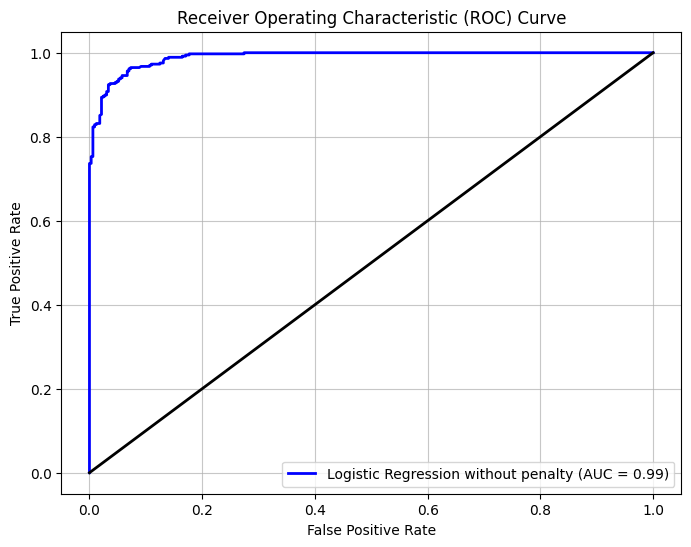

In [29]:
# Train Logistic Regression without penalty
model = LogisticRegression(random_state = 42, penalty = None)
model.fit(X_train_reduced, train['root_label'])
y_pred = model.predict(X_test_reduced)
y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred, "Logistic Regression without penalty")
print("Confusion matrix for logistic regression without penalty:")
cm = confusion_matrix(test['root_label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_prob, "Logistic Regression without penalty")


Logistic Regression with L2 regularization (gamma = 100000)
Accuracy:  0.9425287356321839
Precision:  0.9456521739130435
Recall:  0.9456521739130435
F1 score:  0.9456521739130435

Confusion matrix for logistic regression with L2 regularization (gamma = 100000):


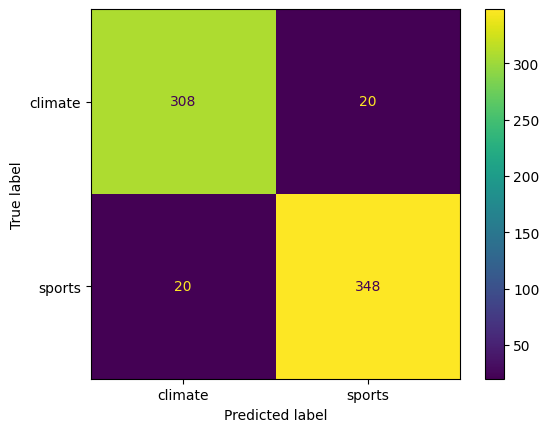

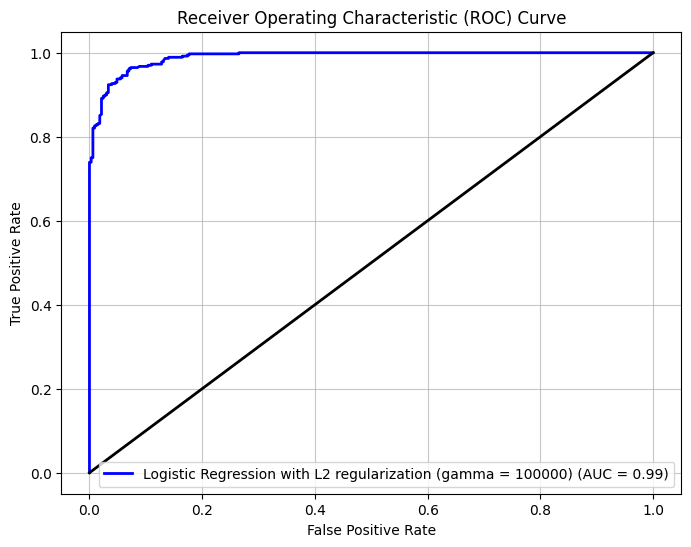

Logistic Regression with L1 regularization (gamma = 1000)
Accuracy:  0.9425287356321839
Precision:  0.9456521739130435
Recall:  0.9456521739130435
F1 score:  0.9456521739130435

Confusion matrix for logistic regression with L1 regularization (gamma = 1000):


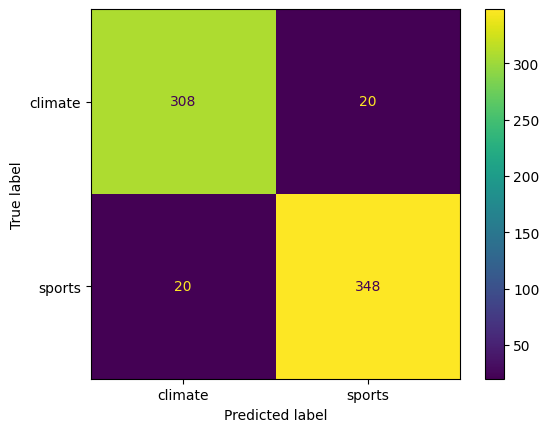

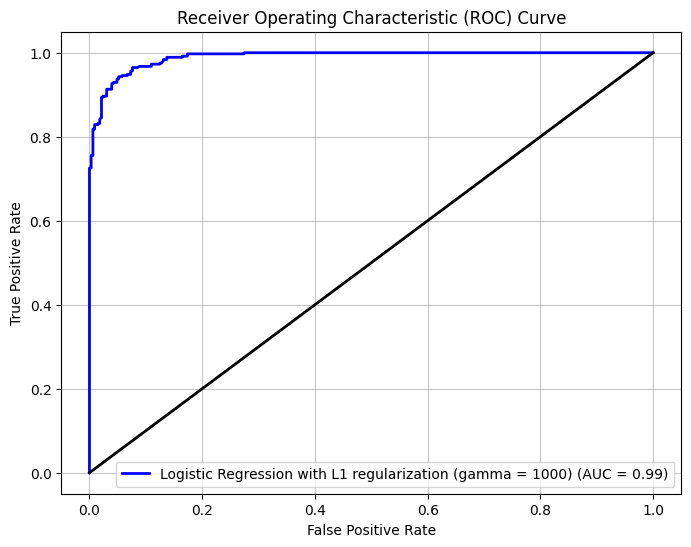

In [30]:
# TODO: Perform 5-fold CV with different penalties

# Define parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

# L1 regularization
model = LogisticRegression(random_state = 42, penalty = 'l2')
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train_reduced, train['root_label'])

# Extract best parameter
best_param = grid_search.best_params_['C']

# Fit model using best parameter
best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l2')
best_model.fit(X_train_reduced, train['root_label'])
y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_best_lr = y_pred_best # Keep for McNemar's test
y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred_best, "Logistic Regression with L2 regularization (gamma = " + str(best_param) + ")")
print("Confusion matrix for logistic regression with L2 regularization (gamma = " + str(best_param) + "):")
cm = confusion_matrix(test['root_label'], y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_best_prob, "Logistic Regression with L2 regularization (gamma = " + str(best_param) + ")")

# L1 regularization
model = LogisticRegression(random_state = 42, penalty = 'l1', solver = 'liblinear')
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train_reduced, train['root_label'])

# Extract best parameter
best_param = grid_search.best_params_['C']

# Fit model using best parameter
best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l1', solver = 'liblinear')
best_model.fit(X_train_reduced, train['root_label'])
y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred_best, "Logistic Regression with L1 regularization (gamma = " + str(best_param) + ")")
print("Confusion matrix for logistic regression with L1 regularization (gamma = " + str(best_param) + "):")
cm = confusion_matrix(test['root_label'], y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_best_prob, "Logistic Regression with L1 regularization (gamma = " + str(best_param) + ")")



In [31]:
# McNemar's test for comparing performance of Logistic Regression and SVM models
# Note: Since all logistic regression models perform identically, arbitrarily model with l2 penalty

# Computations for McNemar's test
y_true = test['root_label']
y_svm = y_pred_best_svm
y_lr = y_pred_best_lr
b = np.sum((y_lr != y_true) & (y_svm == y_true))
c = np.sum((y_lr == y_true) & (y_svm != y_true))

# Construct contingency table
table = np.array([[0, c], [b, 0]])

# Perform McNemar's Test
mcnemar_result = mcnemar(table)

# Print results
print('McNemar Test Results: statistic=%.3f, p-value=%.3f' % (mcnemar_result.statistic, mcnemar_result.pvalue))


McNemar Test Results: statistic=1.000, p-value=0.625


Surprisingly, as shown by the identical confusion matrices and all metrics, the performance of the logistic regression models with all three types of penalties are exactly the same. We note that the AUC curve slightly differs across all models, but the AUC remains at 0.99. We also note that the regularization parameter, gamma, that achieves the optimal performance differs for the two logistic regression models with penalty.

The regularization parameter prevents the model from overfitting the training data. Ideally, this leads to better performance on the test data. In practice, increasing the regularization parameter improves the performance on the test data up until a certain point, in which increasing the regularization parameter further would lead to worse performance (i.e. there may exist an optimal regularization parameter).

L2 regularization seeks to push coefficients to be closer to zero, but not exactly zero. L1 regularization pushes the coefficients of useless features to 0. We may be interested in L2 regularization if we want to retain a richer model with more features. We may also be interested in L1 regularization if we want to perform feature selection and minimize the complexity of the model.

Logistic regression separates data points by assigning a probability that a data point belongs to a particular class. Its underlying objective function is to maximize the conditional probability of a particular class given the input. Based on some threshold (usually 50% probability), the logistic regression model assigns a class to the data point. Linear SVM separates data points by finding some hyperplane that separates the data points from each class. With regularization, its objective function also includes keeping the hyperplane (i.e. the margins) far from data points. This hyperplance is used as a decision boundary.

These two different approaches may lead to slightly different performance. According to the McNemar test, the performances for the two models are not statistically significantly different (p > 0.05).

### Question 7

Naive Bayes
Accuracy:  0.9022988505747126
Precision:  0.875
Recall:  0.9510869565217391
F1 score:  0.9114583333333334

Confusion matrix for naive bayes:


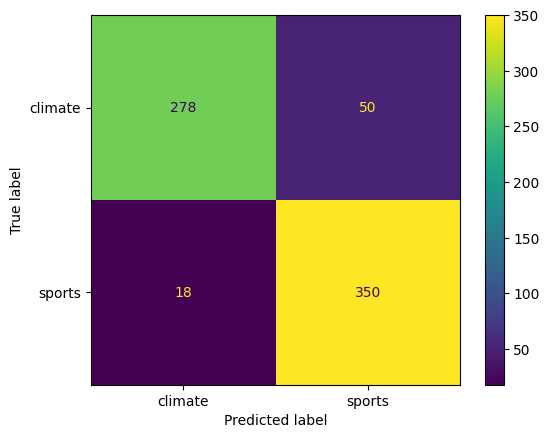

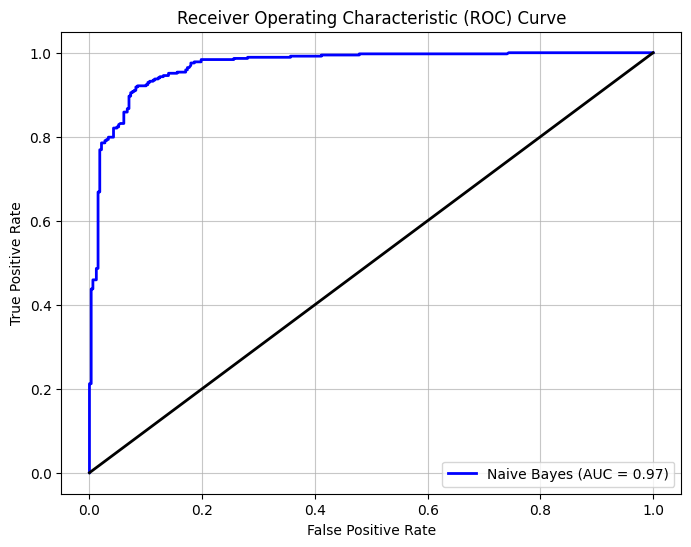

In [32]:
# Naive Bayes model
model = GaussianNB()
model.fit(X_train_reduced, train['root_label'])
y_pred = model.predict(X_test_reduced)
y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

# Metrics
classifier_metrics(test['root_label'], y_pred, "Naive Bayes")
print("Confusion matrix for naive bayes:")
cm = confusion_matrix(test['root_label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()
plt.show()
print()
plot_roc_curve(test['root_label'], y_pred_prob, "Naive Bayes")


### Question 8

(See cleaned notebook)

## Multiclass Classification

In [8]:
# Set seeds
np.random.seed(42)
random.seed(42)

# Load in dataset
df = pd.read_csv("Project 1/data/Project1-ClassificationDataset.csv")

# Split dataset
train, test = train_test_split(df[["full_text", "leaf_label"]], test_size = 0.2)

# Preprocessing
# Make sure clean function is first
preprocessing_functions = [clean, remove_numbers, remove_punctuation, lemmatize]
X_train = preprocessing(train, preprocessing_functions)
X_test = preprocessing(test, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer with min_df = 3
mindf = 3
count_vect = CountVectorizer(stop_words = 'english', min_df = mindf)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Apply LSI with k = 25
svd = TruncatedSVD(n_components = 25, random_state = 42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

### Question 9

TODO: Map row to class, resolve class imbalance, cluster classes

In [9]:
# Modified metrics function
def multiclass_metrics(y_true = list, y_pred = list, model_name = "Model"):
  """
  Prints the metrics for a multiclass classifier.

  Parameters
  ----------
  y_true : list
    The true labels.
  y_pred : list
    The predicted labels.
  model_name : str
    The name of the model.

  Returns
  -------
  None
  """

  # Print metrics
  print(model_name)
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("Precision: ", precision_score(y_true, y_pred, average = 'weighted'))
  print("Recall: ", recall_score(y_true, y_pred, average = 'weighted'))
  print("F1 score: ", f1_score(y_true, y_pred, average = 'weighted'))
  print()

def display_cm_reordered(y_test, y_pred, map, title):
  class_to_index = {v: k for k, v in map.items()}
  
  # Convert word labels to numeric labels
  y_test_numeric = [class_to_index[label] for label in y_test]
  y_pred_numeric = [class_to_index[label] for label in y_pred]

  # Generate the confusion matrix
  cm = confusion_matrix(y_test_numeric, y_pred_numeric)

  # Display the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[map[i] for i in range(len(map))])
  disp.plot(cmap='viridis', xticks_rotation='vertical')  # Adjust visualization
  plt.title(title)
  plt.show()

# Mapping: word labels to numbers
map_row_to_class = {0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer", 5: "forest fire", 6: "flood", 7: "earthquake", 8: "drought", 9: "heatwave"}

Naive Bayes
Accuracy:  0.6738505747126436
Precision:  0.7171593135710114
Recall:  0.6738505747126436
F1 score:  0.6801510087514303



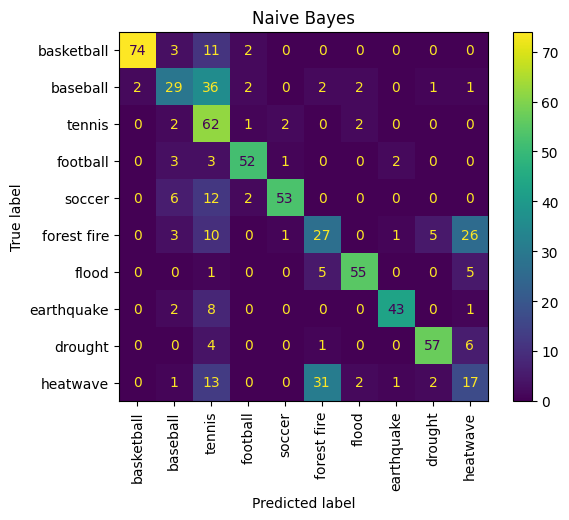

In [10]:
# Naive Bayes Classification
naivebayes = GaussianNB().fit(X_train_reduced, train['leaf_label'])
y_pred = naivebayes.predict(X_test_reduced)

multiclass_metrics(test['leaf_label'], y_pred, "Naive Bayes")
display_cm_reordered(test['leaf_label'], y_pred, map_row_to_class, "Naive Bayes")

SVM (One Vs One)
Accuracy:  0.7097701149425287
Precision:  0.7664698403223332
Recall:  0.7097701149425287
F1 score:  0.7125174806982335



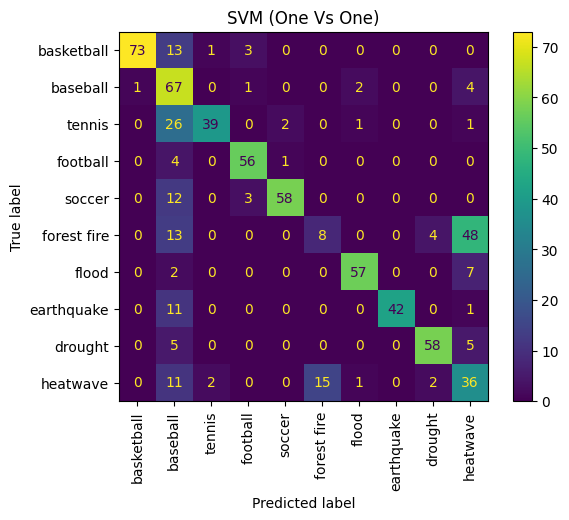

SVM (One vs Rest)
Accuracy:  0.7169540229885057
Precision:  0.6949424787229557
Recall:  0.7169540229885057
F1 score:  0.6902448366765659



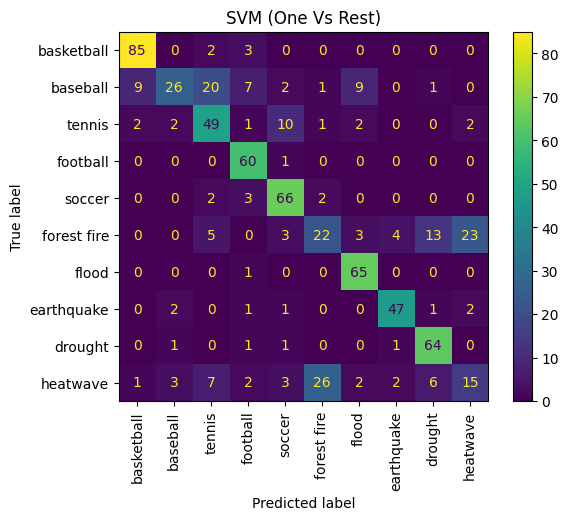

In [11]:
y_train = train['leaf_label']
y_test = test['leaf_label']

# Multiclass SVM (one vs one)
svm = OneVsOneClassifier(SVC(kernel = 'linear', probability = True))
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test, y_pred, "SVM (One Vs One)")
display_cm_reordered(y_test, y_pred, map_row_to_class, "SVM (One Vs One)")

# Multiclass SVM (one vs all)
svm = OneVsRestClassifier(SVC(kernel = 'linear', probability = True))
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test, y_pred, "SVM (One vs Rest)")
display_cm_reordered(y_test, y_pred, map_row_to_class, "SVM (One Vs Rest)")

SVM (One Vs One)
Accuracy:  0.8218390804597702
Precision:  0.857433489594516
Recall:  0.8218390804597702
F1 score:  0.8285038121194649



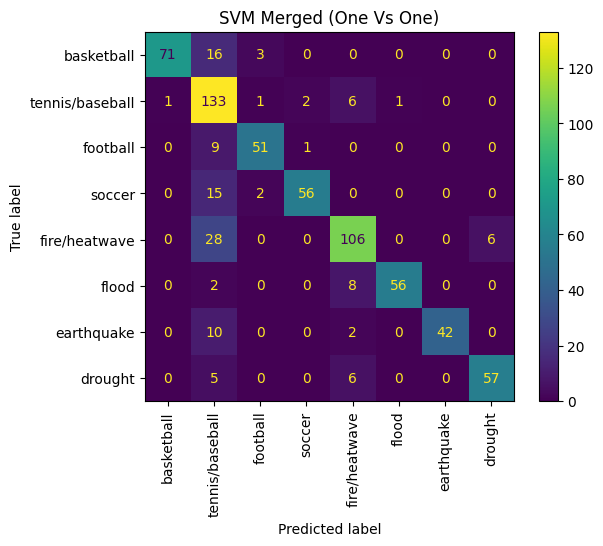

SVM (One Vs Rest)
Accuracy:  0.8721264367816092
Precision:  0.8776517911199219
Recall:  0.8721264367816092
F1 score:  0.873022137745619



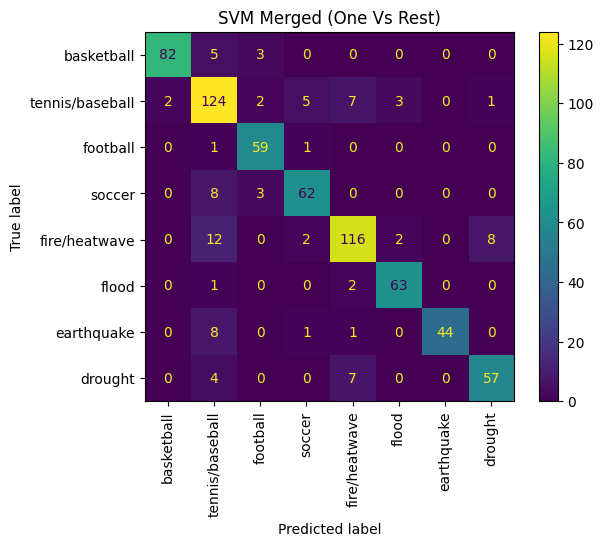

In [12]:
y_train_merged = train['leaf_label'].replace({"forest fire": "fire/heatwave", "heatwave": "fire/heatwave",
                                              "baseball": "tennis/baseball", "tennis": "tennis/baseball"})
y_test_merged = test['leaf_label'].replace({"forest fire": "fire/heatwave", "heatwave": "fire/heatwave",
                                              "baseball": "tennis/baseball", "tennis": "tennis/baseball"})

# Update the label mapping
#map_row_to_class_merged = {0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer", 5: "fire/heatwave", 6: "flood", 7: "earthquake", 8: "drought"}
map_row_to_class_merged = {0: "basketball", 1: "tennis/baseball", 2: "football", 3: "soccer", 4: "fire/heatwave", 5: "flood", 6: "earthquake", 7: "drought"}

# Multiclass SVM (one vs one)
svm = OneVsOneClassifier(SVC(kernel = 'linear', probability = True))
svm.fit(X_train_reduced, y_train_merged)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test_merged, y_pred, "SVM (One Vs One)")
display_cm_reordered(y_test_merged, y_pred, map_row_to_class_merged, "SVM Merged (One Vs One)")

# Multiclass SVM (one vs all)
svm = OneVsRestClassifier(SVC(kernel = 'linear', probability = True))
svm.fit(X_train_reduced, y_train_merged)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test_merged, y_pred, "SVM (One Vs Rest)")
display_cm_reordered(y_test_merged, y_pred, map_row_to_class_merged, "SVM Merged (One Vs Rest)")

SVM (One Vs One)
Accuracy:  0.8477011494252874
Precision:  0.8701708165020714
Recall:  0.8477011494252874
F1 score:  0.8515591752364825



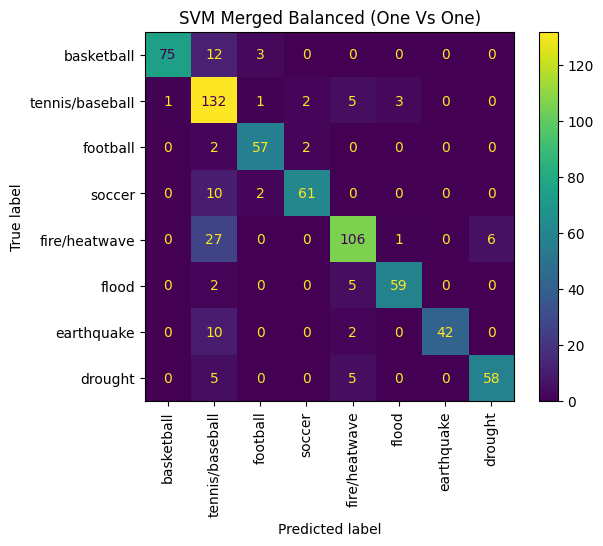

SVM (One Vs Rest)
Accuracy:  0.8620689655172413
Precision:  0.8806050555646461
Recall:  0.8620689655172413
F1 score:  0.86495295697248



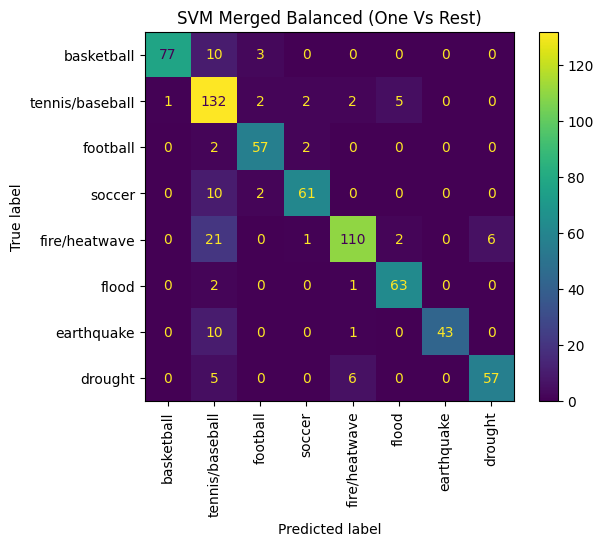

In [13]:
y_train_merged = train['leaf_label'].replace({"forest fire": "fire/heatwave", "heatwave": "fire/heatwave",
                                              "baseball": "tennis/baseball", "tennis": "tennis/baseball"})
y_test_merged = test['leaf_label'].replace({"forest fire": "fire/heatwave", "heatwave": "fire/heatwave",
                                              "baseball": "tennis/baseball", "tennis": "tennis/baseball"})

# Update the label mapping
#map_row_to_class_merged = {0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer", 5: "fire/heatwave", 6: "flood", 7: "earthquake", 8: "drought"}
map_row_to_class_merged = {0: "basketball", 1: "tennis/baseball", 2: "football", 3: "soccer", 4: "fire/heatwave", 5: "flood", 6: "earthquake", 7: "drought"}

# Multiclass SVM (one vs one)
svm = OneVsOneClassifier(SVC(kernel = 'linear', probability = True, class_weight='balanced'))
svm.fit(X_train_reduced, y_train_merged)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test_merged, y_pred, "SVM (One Vs One)")
display_cm_reordered(y_test_merged, y_pred, map_row_to_class_merged, "SVM Merged Balanced (One Vs One)")

# Multiclass SVM (one vs all)
svm = OneVsRestClassifier(SVC(kernel = 'linear', probability = True, class_weight='balanced'))
svm.fit(X_train_reduced, y_train_merged)
y_pred = svm.predict(X_test_reduced)
multiclass_metrics(y_test_merged, y_pred, "SVM (One Vs Rest)")
display_cm_reordered(y_test_merged, y_pred, map_row_to_class_merged, "SVM Merged Balanced (One Vs Rest)")

## Word Embedding

### Question 10

TODO: Read paper and answer subquestions